In [1]:
#!pip install -U datasets seqeval

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random
import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score
import os
import requests
import zipfile

import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)} # converts labels to indices

In [6]:
# Extract sentences and labels
def extract_sentences_and_labels(dataset_split):
    sentences = []
    labels = []
    for item in dataset_split:
        sentences.append(item['tokens'])
        labels.append(item['ner_tags'])
    return sentences, labels

train_sentences, train_labels = extract_sentences_and_labels(dataset['train'])
test_sentences, test_labels = extract_sentences_and_labels(dataset['test'])

# Ensure labels are integers (handles string labels if present)
train_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in train_labels]
test_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in test_labels]

# Download and load GloVe embeddings
glove_path = "glove.6B.100d.txt"
if not os.path.exists(glove_path):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url)
    with open("glove.6B.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("glove.6B.zip", 'r') as zip_ref:
        zip_ref.extractall()

# Load GloVe vectors
glove_model = {}
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_model[word] = vector

# Build vocabulary and embeddings matrix
all_words = set(word for sentence in train_sentences for word in sentence)
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

embedding_matrix = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))

In [7]:
# Prepare input sequences and pad
MAX_LEN = 512
def encode_sentence(sentence):
    ids = [vocab.get(word, 1) for word in sentence]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

def encode_labels(label_seq):
    return label_seq[:MAX_LEN] + [0] * (MAX_LEN - len(label_seq))

X_train = [encode_sentence(sent) for sent in train_sentences]
y_train = [encode_labels(lbls) for lbls in train_labels]
X_test = [encode_sentence(sent) for sent in test_sentences]
y_test = [encode_labels(lbls) for lbls in test_labels]

# Convert to tensors
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [8]:
torch.set_float32_matmul_precision("high")

In [9]:
# Define BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x



In [10]:
batch_size = 32

# Flattened dataset for random access (emulates get_batch)
train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

def get_batch(dataset, batch_size):
    ix = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset[i][0] for i in ix]).to(device)
    y = torch.stack([dataset[i][1] for i in ix]).to(device)
    return x, y

import torch.nn.functional as F

@torch.no_grad()
def estimate_loss(model, eval_steps=10):
    out = {}
    model.eval()
    for name, dataset in [("train", train_dataset), ("test", test_dataset)]:
        losses = torch.zeros(eval_steps)
        accuracies = torch.zeros(eval_steps)
        for k in range(eval_steps):
            x, y = get_batch(dataset, batch_size)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=0)
            losses[k] = loss.item()
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)
            mask = (y != 0)
            correct = (preds == y) & mask
            accuracy = correct.sum().item() / mask.sum().item()
            accuracies[k] = accuracy
        
        out[name] = {
            "loss": losses.mean().item(),
            "accuracy": accuracies.mean().item()
        }
    model.train()
    return out

In [11]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_model(model, optimizer): 
    model.to(device)
    max_iters = 2000
    eval_interval = 200
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    eval_steps = []

    lossi = []

    for step in range(max_iters):
        if step % eval_interval == 0:
            metrics = estimate_loss(model)
            
            train_losses.append(metrics['train']['loss'])
            test_losses.append(metrics['test']['loss'])
            train_accuracies.append(metrics['train']['accuracy'])
            test_accuracies.append(metrics['test']['accuracy'])
            eval_steps.append(step)

            print(
                f"Step {step}: "
                f"Train loss {metrics['train']['loss']:.4f}, accuracy {metrics['train']['accuracy']:.4f} | "
                f"Test loss {metrics['test']['loss']:.4f}, accuracy {metrics['test']['accuracy']:.4f}"
            )
        
        xb, yb = get_batch(train_dataset, batch_size)
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), yb.view(-1), ignore_index=0)
        
        lossi.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plotting losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_steps, train_losses, label="Train Loss")
    plt.plot(eval_steps, test_losses, label="Test Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss over Time")
    plt.legend()
    plt.grid(True)

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, train_accuracies, label="Train Accuracy")
    plt.plot(eval_steps, test_accuracies, label="Test Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [12]:
def evaluate_model(model):
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        pred_labels = torch.argmax(predictions, dim=2).cpu().numpy()
    
    true_labels = y_test.cpu().numpy()
    
    # Format for evaluation
    true_str = []
    pred_str = []
    for t_seq, p_seq in zip(true_labels, pred_labels):
        temp_true = []
        temp_pred = []
        for t, p in zip(t_seq, p_seq):
            if t != 0:
                temp_true.append(labels[t])
                temp_pred.append(labels[p])
        true_str.append(temp_true)
        pred_str.append(temp_pred)
    
    # Detailed evaluation report
    print("Classification Report:\n")
    print(classification_report(true_str, pred_str))
    print("F1 Score:", f1_score(true_str, pred_str))
    print("Accuracy:", accuracy_score(true_str, pred_str))

    flat_true = [ltoi[l] for seq in true_str for l in seq]
    flat_pred = [ltoi[l] for seq in pred_str for l in seq]
    
    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  # <-- Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Step 0: Train loss 1.3737, accuracy 0.3051 | Test loss 1.3708, accuracy 0.3547
Step 200: Train loss 0.7093, accuracy 0.7225 | Test loss 0.7071, accuracy 0.7270
Step 400: Train loss 0.3954, accuracy 0.8748 | Test loss 0.4061, accuracy 0.8696
Step 600: Train loss 0.2995, accuracy 0.9015 | Test loss 0.3104, accuracy 0.8882
Step 800: Train loss 0.2312, accuracy 0.9247 | Test loss 0.2709, accuracy 0.9092
Step 1000: Train loss 0.1907, accuracy 0.9351 | Test loss 0.2743, accuracy 0.9000
Step 1200: Train loss 0.1738, accuracy 0.9450 | Test loss 0.2546, accuracy 0.8992
Step 1400: Train loss 0.1581, accuracy 0.9503 | Test loss 0.2531, accuracy 0.9070
Step 1600: Train loss 0.1379, accuracy 0.9581 | Test loss 0.2358, accuracy 0.9193
Step 1800: Train loss 0.1111, accuracy 0.9651 | Test loss 0.2383, accuracy 0.9186


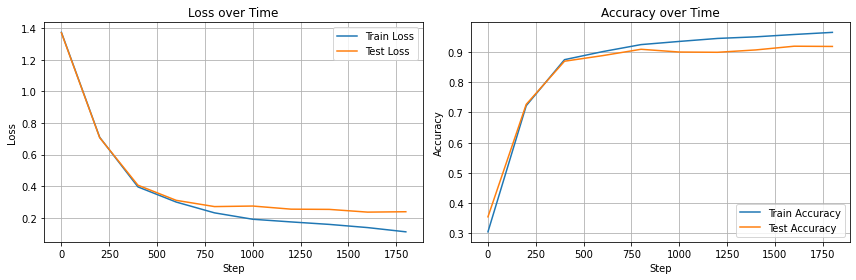

Classification Report:

              precision    recall  f1-score   support

          AC       0.88      0.95      0.92       797
          LF       0.78      0.85      0.81       482

   micro avg       0.84      0.91      0.88      1279
   macro avg       0.83      0.90      0.86      1279
weighted avg       0.84      0.91      0.88      1279

F1 Score: 0.8759835144248783
Accuracy: 0.9118116520351157


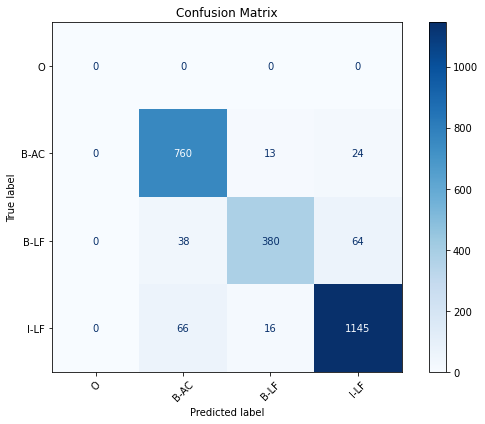

In [13]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3846, accuracy 0.2272 | Test loss 1.3809, accuracy 0.2376
Step 200: Train loss 1.2959, accuracy 0.4894 | Test loss 1.2966, accuracy 0.5010
Step 400: Train loss 1.2101, accuracy 0.4841 | Test loss 1.2030, accuracy 0.5077
Step 600: Train loss 1.0996, accuracy 0.4665 | Test loss 1.1058, accuracy 0.4777
Step 800: Train loss 1.0018, accuracy 0.4862 | Test loss 1.0028, accuracy 0.4970
Step 1000: Train loss 0.9401, accuracy 0.5887 | Test loss 0.9393, accuracy 0.6144
Step 1200: Train loss 0.8818, accuracy 0.6526 | Test loss 0.8946, accuracy 0.6584
Step 1400: Train loss 0.8294, accuracy 0.6929 | Test loss 0.8317, accuracy 0.6880
Step 1600: Train loss 0.7898, accuracy 0.6974 | Test loss 0.7860, accuracy 0.6990
Step 1800: Train loss 0.7452, accuracy 0.7101 | Test loss 0.7411, accuracy 0.7065


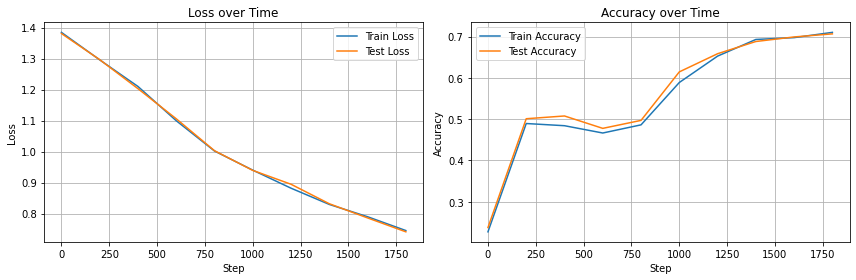

Classification Report:

              precision    recall  f1-score   support

          AC       0.73      0.86      0.79       797
          LF       0.50      0.60      0.54       482

   micro avg       0.64      0.76      0.70      1279
   macro avg       0.62      0.73      0.67      1279
weighted avg       0.64      0.76      0.70      1279

F1 Score: 0.6972083035075162
Accuracy: 0.729050279329609


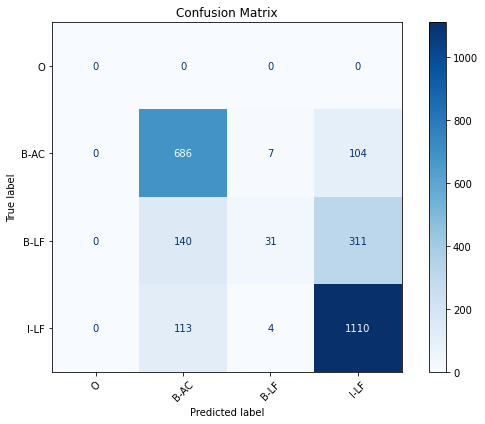

In [14]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3844, accuracy 0.2798 | Test loss 1.3812, accuracy 0.3288
Step 200: Train loss 0.1599, accuracy 0.9403 | Test loss 0.2246, accuracy 0.9242
Step 400: Train loss 0.0827, accuracy 0.9770 | Test loss 0.1834, accuracy 0.9313
Step 600: Train loss 0.0197, accuracy 0.9958 | Test loss 0.2194, accuracy 0.9269
Step 800: Train loss 0.0069, accuracy 0.9991 | Test loss 0.2032, accuracy 0.9389
Step 1000: Train loss 0.0017, accuracy 1.0000 | Test loss 0.3032, accuracy 0.9158
Step 1200: Train loss 0.0008, accuracy 1.0000 | Test loss 0.2607, accuracy 0.9303
Step 1400: Train loss 0.0006, accuracy 1.0000 | Test loss 0.2724, accuracy 0.9304
Step 1600: Train loss 0.0004, accuracy 1.0000 | Test loss 0.4221, accuracy 0.9028
Step 1800: Train loss 0.0003, accuracy 1.0000 | Test loss 0.3017, accuracy 0.9269


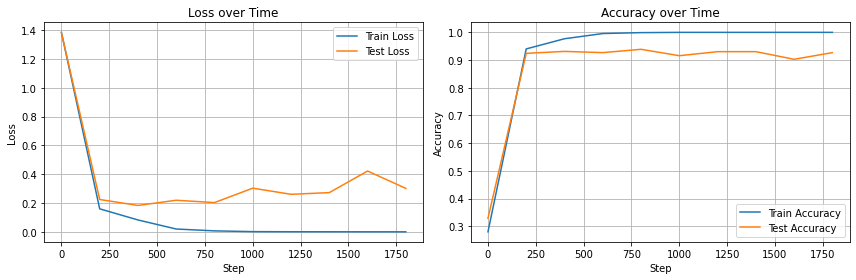

Classification Report:

              precision    recall  f1-score   support

          AC       0.91      0.96      0.94       797
          LF       0.79      0.86      0.82       482

   micro avg       0.87      0.92      0.89      1279
   macro avg       0.85      0.91      0.88      1279
weighted avg       0.87      0.92      0.89      1279

F1 Score: 0.8922610015174507
Accuracy: 0.926975259377494


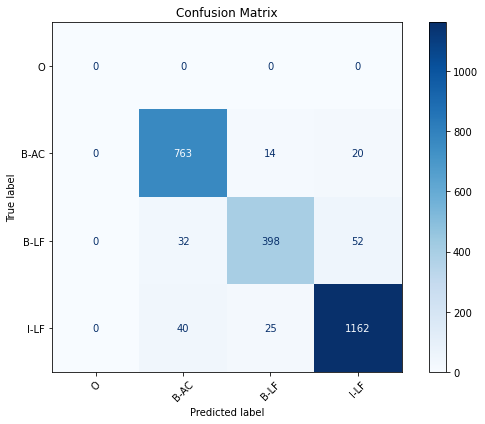

In [15]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.4098, accuracy 0.1552 | Test loss 1.3978, accuracy 0.2301
Step 200: Train loss 0.5806, accuracy 0.7817 | Test loss 0.5581, accuracy 0.7887
Step 400: Train loss 0.3941, accuracy 0.8659 | Test loss 0.3753, accuracy 0.8797
Step 600: Train loss 0.3350, accuracy 0.8847 | Test loss 0.3379, accuracy 0.8824
Step 800: Train loss 0.2910, accuracy 0.9030 | Test loss 0.2988, accuracy 0.8937
Step 1000: Train loss 0.2504, accuracy 0.9120 | Test loss 0.2972, accuracy 0.9008
Step 1200: Train loss 0.2271, accuracy 0.9255 | Test loss 0.2813, accuracy 0.8966
Step 1400: Train loss 0.2149, accuracy 0.9336 | Test loss 0.2873, accuracy 0.8923
Step 1600: Train loss 0.2205, accuracy 0.9294 | Test loss 0.2293, accuracy 0.9163
Step 1800: Train loss 0.1953, accuracy 0.9294 | Test loss 0.2077, accuracy 0.9295


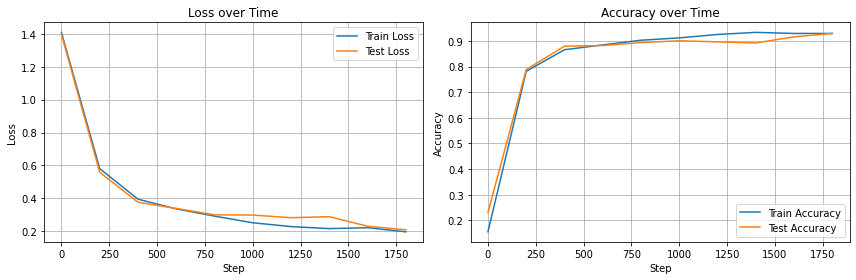

Classification Report:

              precision    recall  f1-score   support

          AC       0.92      0.95      0.93       797
          LF       0.75      0.85      0.79       482

   micro avg       0.85      0.91      0.88      1279
   macro avg       0.83      0.90      0.86      1279
weighted avg       0.85      0.91      0.88      1279

F1 Score: 0.8783068783068783
Accuracy: 0.9154030327214685


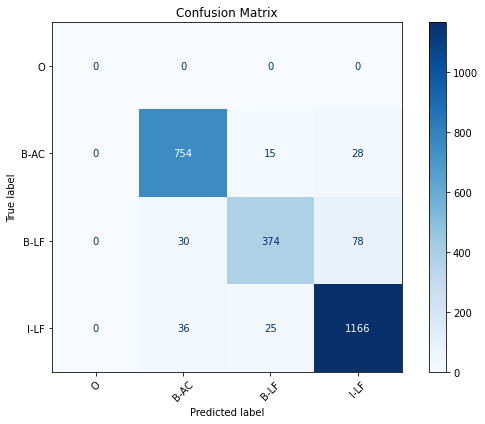

In [16]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)